# Distributed Compressed Sensing
## Parameter Definition and Centralized Optimization

The mathematical formulation of this problem is:

$$
\min_{x \in \mathbb{R}^d} \quad \frac{1}{16} \sum_{i = 1}^{16} (C_i \Psi \hat{s} - y_i)^2 + \lambda \| x \|_1
$$

Here, $C_i$ denotes the measurement matrix (in this case, randomly selected rows of the identity matrix), and $\Psi$ is the discrete cosine transform basis. The final solution is denoted as $\hat{s}^*$.


In [1]:
if __name__ == "__main__":
    import numpy as np
    import cvxpy as cp
    from numpy.typing import NDArray
    from scipy.fftpack import fft, dct

    # Sensors
    n_sens = 16
    sens_names = [f"{i + 1}" for i in range(n_sens)]

    # Original signal
    n = 4096
    t = np.linspace(0, 1, n)
    x = np.cos(2 * 97 * np.pi * t) + np.cos(2 * 777 * np.pi * t)
    xt = fft(x)
    psd = (np.abs(xt) ** 2) / n

    # Signal sampling
    np.random.seed(3)
    p_total = 128
    p_sens = p_total // n_sens
    perm = {i: np.round(np.random.rand(p_sens) * n).astype(int) for i in sens_names}
    y = {i: x[perm[i]] for i in sens_names}

    # Sensing matrix and regularization parameter
    Psi = dct(np.eye(n), norm="ortho")
    Theta = {i: Psi[perm[i], :] for i in sens_names}
    lam = 0.01

    # Centralized optimization
    s_hat = cp.Variable(n)
    cost = sum(
        [cp.norm2(Theta[i] @ s_hat - y[i]) ** 2 for i in sens_names]
    ) / n_sens + lam * cp.norm1(s_hat)
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve(solver=cp.ECOS)

    s_hat_star: NDArray[np.float64] = np.asarray(s_hat.value)

    print(f"Centralized optimization result: {s_hat_star}")

Centralized optimization result: [-3.11062644e-12  4.41373983e-12 -1.98379001e-12 ... -2.45602406e-12
 -3.54234338e-13 -1.71501921e-12]


/home/rui/code/discoopt/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


### Global Matplotlib Plotting Parameters and Sensor Color Scheme

In [2]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    plt.rcParams["text.usetex"] = True  # 使用外部 LaTeX 编译器
    plt.rcParams["font.family"] = "serif"  # 设置字体为 LaTeX 的默认 serif 字体

    plt.rcParams.update(
        {
            "font.size": 14,  # 全局字体大小
            "axes.titlesize": 16,  # 坐标轴标题字体大小
            "axes.labelsize": 16,  # 坐标轴标签字体大小
            "xtick.labelsize": 16,  # x轴刻度标签字体大小
            "ytick.labelsize": 16,  # y轴刻度标签字体大小
            "legend.fontsize": 13,  # 图例字体大小
        }
    )

    sens_color = {
        "1": "#1f77b4",  # 蓝色
        "2": "#ff7f0e",  # 橙色
        "3": "#2ca02c",  # 绿色
        "4": "#d62728",  # 红色
        "5": "#9467bd",  # 紫色
        "6": "#8c564b",  # 棕色
        "7": "#e377c2",  # 粉色
        "8": "#7f7f7f",  # 灰色
        "9": "#bcbd22",  # 黄绿色
        "10": "#17becf",  # 青色
        "11": "#393b79",  # 深蓝
        "12": "#52519e",  # 蓝紫色
        "13": "#6b4196",  # 紫罗兰
        "14": "#85397e",  # 深紫红
        "15": "#7f4172",  # 梅红色
        "16": "#7f4e52",  # 深红棕
    }

### Original signal with multi-sensor sampling

Each sensor samples the original signal at 8 Hz using random time points, as illustrated by the colored crosses corresponding to each sensor.

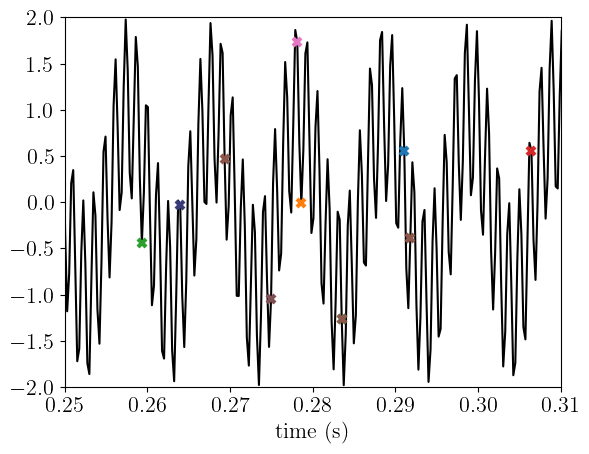

In [3]:
if __name__ == "__main__":
    fig1, ax1 = plt.subplots()
    ax1.set_xlim((0.25, 0.31))
    ax1.set_ylim((-2, 2))

    ax1.plot(t, x, "k")
    for i in sens_names:
        ax1.plot(t[perm[i]], y[i], "x", color=sens_color[i], markeredgewidth=3)

    ax1.set_xlabel("time (s)")

### Original signal PSD

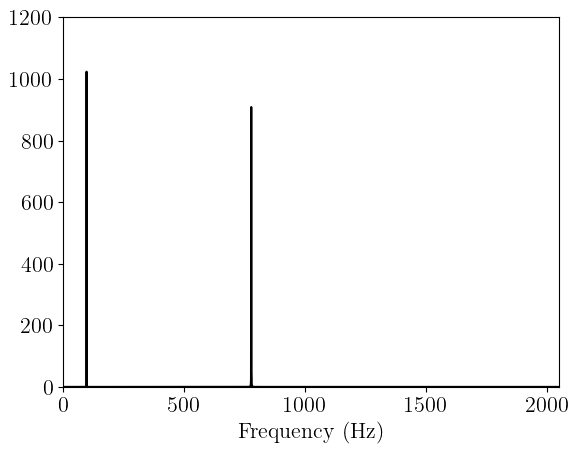

In [4]:
if __name__ == "__main__":
    fig2, ax2 = plt.subplots()
    ax2.set_xlim((0, n // 2))
    ax2.set_ylim((0, 1200))
    ax2.set_xlabel("Frequency (Hz)")

    ax2.plot(psd[: n // 2], "k")

## Benchmarking Distributed Optimization Algorithms

In this section, we evaluate the distributed optimization algorithms `RAugDGM`, `RGT`, `WE`, and `RGT` on the ridge regression problem. Each algorithm is run with its corresponding step size, and their performance is compared using mean squared error (MSE):

$$
\frac{1}{16n} \sum_{i = 1}^{4} || \hat{s}_i - \hat{s}^* ||^2
$$

across iterations, where $\hat{s}_i, \hat{s}^* \in \mathbb{R}^n$.

The network topology is a $4 \times 4$ grid, and the gossip matrix is defined as $W = I - 0.1L$, with $L$ being the Laplacian matrix of the graph.


In [ ]:
from numpy import float64
from multiprocessing import Pool
from numpy.typing import NDArray


def graph() -> None:
    import networkx as nx
    from numpy import eye, asarray

    n_grid = 4
    grid = nx.grid_2d_graph(n_grid, n_grid)
    L: NDArray[np.float64] = asarray(nx.laplacian_matrix(grid))
    W = eye(16) - L * 0.1

    from topolink import Graph

    graph = Graph.from_mixing_matrix(W)
    graph.deploy()


def lasso(
    node_id: str,
    theta_i: NDArray[float64],
    y_i: NDArray[float64],
    dim_i: int,
    lam_i: float,
    gamma: float,
    algorithm: str,
    optimal_solution: NDArray[float64],
) -> tuple[NDArray[float64], NDArray[float64]]:
    from numpy import zeros

    max_iter = 7000
    s_hat_i = zeros((max_iter, dim_i), dtype=float64)

    # Define the loss function
    from numpy import mean
    from jax import Array
    from jax.numpy.linalg import norm

    def f(var: NDArray[float64]) -> Array:
        return norm(theta_i @ var - y_i) ** 2

    # Define the regularizer
    from discoopt.regularizer import L1

    g = L1(lam_i)

    # Define the node handle with masking
    from numpy.random import normal
    from topolink import NodeHandle

    def mask(x: NDArray[float64]) -> NDArray[float64]:
        return x + normal(0, 0.002, size=x.shape)

    nh = NodeHandle(node_id, mask=mask)

    # Define the optimizer and run iterations
    from discoopt import Optimizer

    optimizer = Optimizer.get_class(algorithm)(f, nh, gamma, g)

    optimizer.init(s_hat_i[0])

    for k in range(max_iter - 1):
        s_hat_i[k + 1] = optimizer.step(s_hat_i[k])

    final_iteration = s_hat_i[-1]
    mse_evolution = mean((s_hat_i - optimal_solution) ** 2, axis=1)

    return final_iteration, mse_evolution


if __name__ == "__main__":
    step_sizes = {"RAugDGM": 1.358, "AtcWE": 1.123, "WE": 0.893, "RGT": 0.656}
    recovered_signal: NDArray[float64]
    mse_by_algorithm: dict[str, NDArray[float64]] = {}

    with Pool(n_sens + 1) as pool:
        for alg, gam in step_sizes.items():
            tasks = [
                pool.apply_async(
                    lasso, args=(i, Theta[i], y[i], n, lam, gam, alg, s_hat_star)
                )
                for i in sens_names
            ]

            pool.apply(graph)

            results = [task.get() for task in tasks]

            if alg == "RAugDGM":
                recovered_signal = results[3][0]
            mse_by_algorithm[alg] = np.mean([res[1] for res in results], axis=0)

            print(f"Algorithm: {alg}, Step size: {gam}, Finished!")

<class 'jaxlib._jax.ArrayImpl'><class 'jaxlib._jax.ArrayImpl'><class 'jaxlib._jax.ArrayImpl'><class 'jaxlib._jax.ArrayImpl'><class 'jaxlib._jax.ArrayImpl'> <class 'jaxlib._jax.ArrayImpl'> <class 'jaxlib._jax.ArrayImpl'>     1.08705541.00621431.0354505<class 'jaxlib._jax.ArrayImpl'>0.983068171.1916814


1.3469435<class 'jaxlib._jax.ArrayImpl'> 1.0152376
 
<class 'jaxlib._jax.ArrayImpl'><class 'jaxlib._jax.ArrayImpl'><class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>
1.026487   1.06431041.10383651.0579633 

1.0520232

1.1244015

<class 'jaxlib._jax.ArrayImpl'> 1.1945268
<class 'jaxlib._jax.ArrayImpl'> 1.0735658
<class 'jaxlib._jax.ArrayImpl'> 1.1046981
<class 'jaxlib._jax.ArrayImpl'><class 'jaxlib._jax.ArrayImpl'><class 'jaxlib._jax.ArrayImpl'> <class 'jaxlib._jax.ArrayImpl'><class 'jaxlib._jax.ArrayImpl'> <class 'jaxlib._jax.ArrayImpl'>1.3469435    
1.19168141.00621431.03545051.01523761.0870554


<class 'jaxlib._jax.ArrayImpl'>

<class 'jaxlib._jax.ArrayImpl'><class 'jaxlib

<class 'jaxlib._jax.ArrayImpl'> 1.026487
Algorithm: RAugDGM, Step size: 1.358, Finished!
<class 'jaxlib._jax.ArrayImpl'><class 'jaxlib._jax.ArrayImpl'><class 'jaxlib._jax.ArrayImpl'><class 'jaxlib._jax.ArrayImpl'>  <class 'jaxlib._jax.ArrayImpl'>  <class 'jaxlib._jax.ArrayImpl'>1.0264871.3469435<class 'jaxlib._jax.ArrayImpl'> 1.01523761.1916814
 <class 'jaxlib._jax.ArrayImpl'><class 'jaxlib._jax.ArrayImpl'>


1.0354505 1.0062143  <class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>
1.0870554 1.05796330.98306817 <class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>1.0735658

<class 'jaxlib._jax.ArrayImpl'> 1.1038365<class 'jaxlib._jax.ArrayImpl'>
<class 'jaxlib._jax.ArrayImpl'>  
 1.0520232 1.1244015

1.06431041.10469811.1945268


Algorithm: AtcWE, Step size: 1.123, Finished!
<class 'jaxlib._jax.ArrayImpl'><class 'jaxlib._jax.ArrayImpl'><class 'jaxlib._jax.ArrayImpl'> <class 'jaxlib._jax.ArrayImpl'>  <class 'jaxlib._jax.ArrayImpl'>1.026487<class 'jaxlib._jax.ArrayIm

## Plot results

### Evolution of the MSE for `RAugDGM`, `RGT`, `WE`, and `RGT`

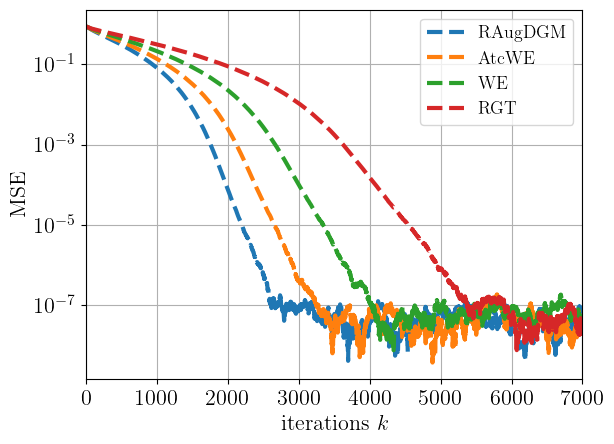

In [ ]:
if __name__ == "__main__":
    fig3, ax3 = plt.subplots()
    ax3.set_xlim((0, 7000))
    ax3.set_xlabel("iterations $k$")
    ax3.set_ylabel("MSE")

    line_options = {"linewidth": 3, "linestyle": "--"}

    for alg, mse in mse_by_algorithm.items():
        ax3.semilogy(mse, label=alg, **line_options)

    ax3.legend(loc="upper right")
    ax3.grid(True, which="major", linestyle="-", linewidth=0.8)

### Reconstructed signal at a representative node (all nodes exhibit similar performance)

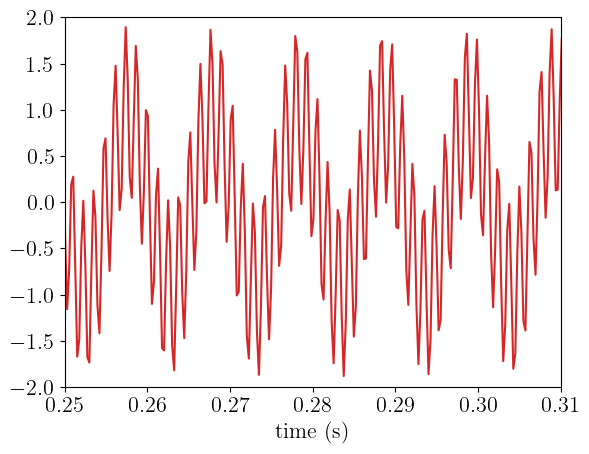

In [ ]:
if __name__ == "__main__":
    from scipy.fftpack import idct

    fig4, ax4 = plt.subplots()

    x_recon = idct(recovered_signal, norm="ortho").reshape(-1)

    ax4.plot(t, x_recon, color=sens_color["4"])

    ax4.set_xlim((0.25, 0.31))
    ax4.set_ylim((-2, 2))
    ax4.set_xlabel("time (s)")

### Reconstructed PSD

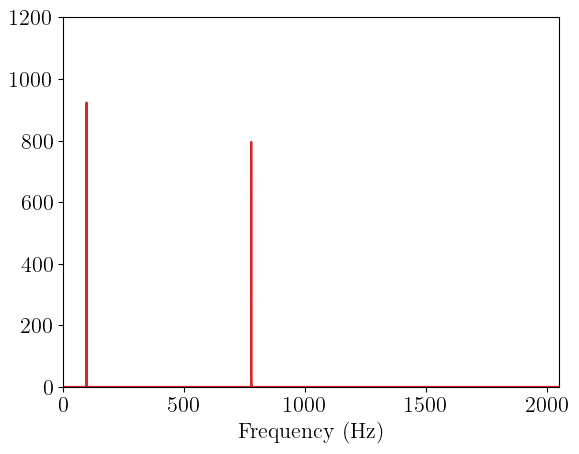

In [ ]:
if __name__ == "__main__":
    fig5, ax5 = plt.subplots()

    x_recon_t = fft(x_recon)
    psd_recon = (np.abs(x_recon_t) ** 2) / n

    ax5.set_xlim((0, n // 2))
    ax5.set_ylim((0, 1200))
    ax5.set_xlabel("Frequency (Hz)")
    ax5.plot(psd_recon[: n // 2], color=sens_color["4"])